# LIBRARIES

In [1]:
import pickle 
from regret_bound import *
from Environment import *
from UserCat import UserCat
from Product import Product
from Greedy_optimizer import *
import numpy as np
import matplotlib.pyplot as plt
from step3_ucb1 import *
from step4_ucb1 import *
from step5_ucb1 import *
from step6_sw_ucb import *
from Step6_CD import *
from step7_ucb1 import *
from Step3_TS import *
from Step4_TS import *
from Step5_TS import *
from Step6_TS_sw import *
from Step7_TS import *


# ENVIRONMENT DEFINITION 

In [4]:
x = [0.20913777, 0.20950131, 0.20980038, 0.20919609, 0.20943129]
x/np.sum(x)

array([0.19973679, 0.20008399, 0.20036962, 0.19979249, 0.20001712])

- Environment fixed informations and Products definition

In [2]:
np.random.seed(1)

products=[]

nameofproduct= [ #name of products
    "Calabazas",
    "Hinojo",
    "Sesamo",
    "Girasol",
    "Amapola"
]
# Dictionary fixing the secondary products linked to
secondary_dict= {
    "Calabazas": [1,2],
    "Hinojo": [0,2],
    "Sesamo": [3,1],
    "Girasol": [2,4],
    "Amapola": [3,2]
}

# Matrix n_prod*n_prices collecting the possible prices for each product. Prices are in ascending order
prices = [[6.5, 8, 9.5, 11],
          [11., 12, 13, 16],
          [20., 21, 22, 25],
          [27., 29, 31, 37],
          [40., 41, 44, 48]]
# Production cost of the products
cost = [4.75, 9.75, 13.5, 15.75, 15.75]

#sarebbe interessante anche prendere da file il tutto così da cambiare tutto più facilmente
#calcolo i margini dai cost mi sembra più sensato e anche più veloce se dobbiamo cambiare continuamente
# Computation of margins linked to each product for a particular choice of price
cost2 = np.tile(np.array([cost]).transpose(), (1, 4))
margins = np.array(prices)-cost2
# Creation of the 5 objects of Product class
for i in range (5):
    products.append(Product(prices[i], i, nameofproduct[i],margins[i]))

# Parameter for the computation of the click probability on the SECOND secondary product
lambda_q = 0.7

- User Category 1: Young and Inexpert

In [3]:
# Parameters for the distribution describing the reservation price
res_price_params_1 = {
    "mean": [8.5, 13, 21.5, 28, 40],
    "std": [1, 1.5, 2, 2.5, 3]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_1 = [[0, 0.6, 0.2, 0, 0],
                 [0.4, 0, 0.4, 0, 0],
                 [0, 0.6, 0, 0.2, 0],
                 [0, 0, 0.3, 0, 0.1],
                 [0, 0, 0.2, 0.4, 0]]
prob_lambda_1 = lambda_correct(np.matrix(probabilities_1), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_1 = [15, 15, 10, 5, 5]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_1 = [2, 1, .5, .2, .1]

user1 = UserCat(alphas_1, res_price_params_1, poisson_lambda_1, prob_lambda_1, 'Young and Not Expert')

- User Category 2: Old and Inexpert

In [4]:
# Parameters for the distribution describing the reservation price
res_price_params_2 = {
    "mean": [9, 14, 25, 32, 44],
    "std": [3, 1.5, 2.5, 3.5, 4]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_2 = [[0, 0.4, 0.3, 0, 0],
                 [0.3, 0, 0.5, 0, 0],
                 [0, 0.5, 0, 0.4, 0],
                 [0, 0, 0.4, 0, 0.2],
                 [0, 0, 0.4, 0.2, 0]]
prob_lambda_2 = lambda_correct(np.matrix(probabilities_2), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_2 = [7, 12, 12, 12, 7]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_2 = [0.6, 1.1, 2, 0.9, 0.5]

user2 = UserCat(alphas_2, res_price_params_2, poisson_lambda_2, prob_lambda_2, 'Old and Not Expert')

- User Category 3: Expert

In [5]:
# Parameters for the distribution describing the reservation price
res_price_params_3 = {
    "mean": [7.5, 12, 23, 37, 49],
    "std": [1.5, 1.5, 2, 4, 3.5]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_3 = [[0, 0.3, 0.4, 0, 0],
                 [0.3, 0, 0.2, 0, 0],
                 [0, 0.3, 0, 0.5, 0],
                 [0, 0, 0.2, 0, 0.6],
                 [0, 0, 0.3, 0.5, 0]]
prob_lambda_3 = lambda_correct(np.matrix(probabilities_3), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_3 = [5, 5, 10, 15, 15]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_3 = [0.1, 0.2, 0.5, 1.5, 1.2]

user3 = UserCat(alphas_3, res_price_params_3, poisson_lambda_3, prob_lambda_3, 'Expert')

- User Category 0: Aggregated demand

In [6]:
# Parameters for the distribution describing the reservation price
res_price_params_0 = {
    "mean": [9, 13, 22, 35, 42],
    "std": [3, 1.5, 2, 2.5, 2.5]
}

# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_0 = [[0, 0.5, 0.2, 0, 0],
                 [0.4, 0, 0.3, 0, 0],
                 [0, 0.4, 0, 0.4, 0],
                 [0, 0, 0.5, 0, 0.4],
                 [0, 0, 0.2, 0.4, 0]]
prob_lambda_0 = lambda_correct(np.matrix(probabilities_0), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_0 = [10, 10, 10, 10, 10]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_0 = [1.5, 1, .5, .4, .2]

user0 = UserCat(alphas_0, res_price_params_0, poisson_lambda_0, prob_lambda_0)

- Environment creation

In [7]:
# COMMON
# probability distribution of the features
# the following list has to be interpreted in the following way:
# values_i is the parameter of the bernoulli for feature i; in our case feature0 is 1(0) for Expert(Not Expert)
# while feature1 is 1(0) for Old(Young)
feature_prob = [0.3, 0.4]
# CASE WITH 3 USERS :
# list of users 
users3 = [user1, user2, user3]
feature_matrix3 = np.array([[0, 1], [2, 2]]) # values represent the label of the User Category
env3 = Environment(users3, products, secondary_dict, feature_matrix3, feature_prob)

# CASE WITH AGGREGATED USER :
users0 = [user0]
feature_matrix0 = np.array([[0, 0], [0, 0]])
env = Environment(users0, products, secondary_dict, feature_matrix0, feature_prob)

- Upper Bound for Cumulative Regret

In [8]:
ub_ts = TS_regret(env, 365, 1e-3)
ub_ucb = ucb_regret(env, 365)

## Parameters chosen for the Users

### - Conversion Rates

In [9]:
user = 0
cr = np.matrix(env.theoretical_values['conversion_rates'][user])
print('Conversion Rates for aggregated user :\n %s' %cr)

user = 0
cr = np.matrix(env3.theoretical_values['conversion_rates'][user])
print('\nConversion Rates for Young user :\n %s' %cr)

user = 1
cr = np.matrix(env3.theoretical_values['conversion_rates'][user])
print('\nConversion Rates for Old user :\n %s' %cr)

user = 2
cr = np.matrix(env3.theoretical_values['conversion_rates'][user])
print('\nConversion Rates for Expert user :\n %s' %cr)

Conversion Rates for aggregated user :
 [[0.79767162 0.63055866 0.43381617 0.25249254]
 [0.90878878 0.74750746 0.5        0.02275013]
 [0.84134475 0.69146246 0.5        0.0668072 ]
 [0.99931286 0.99180246 0.94520071 0.2118554 ]
 [0.7881446  0.65542174 0.2118554  0.00819754]]

Conversion Rates for Young user :
 [[9.77249868e-01 6.91462461e-01 1.58655254e-01 6.20966533e-03]
 [9.08788780e-01 7.47507462e-01 5.00000000e-01 2.27501319e-02]
 [7.73372648e-01 5.98706326e-01 4.01293674e-01 4.00591569e-02]
 [6.55421742e-01 3.44578258e-01 1.15069670e-01 1.59108590e-04]
 [5.00000000e-01 3.69441340e-01 9.12112197e-02 3.83038057e-03]]

Conversion Rates for Old user :
 [[0.79767162 0.63055866 0.43381617 0.25249254]
 [0.97724987 0.90878878 0.74750746 0.09121122]
 [0.97724987 0.94520071 0.88493033 0.5       ]
 [0.92343627 0.80431703 0.61245152 0.07656373]
 [0.84134475 0.77337265 0.5        0.15865525]]

Conversion Rates for Expert user :
 [[0.74750746 0.36944134 0.09121122 0.00981533]
 [0.74750746 0.5  

### - Optimal Reward e Optimal Combination

In [10]:
aggr_opt_reward, aggr_opt_comb = env.optimal_reward()
print('-------------------------- Aggregated User ----------------------------')
print( 'Aggregated Optimal Reward : %.3f - Optimal Combination : %s' %(aggr_opt_reward, aggr_opt_comb))
print('-------------------------- 3 classes Users ----------------------------')
opt_rewards_array, opt_comb_list = env3.optimal_reward(Disaggregated=True)
aggr_opt_reward, aggr_opt_comb = env3.optimal_reward()
dis_opt_reward = np.sum(np.array(env3.user_cat_prob)*opt_rewards_array)
print('Aggregated Optimal Reward : %.3f VS Disaggregated Optimal Reward : %.3f' %(aggr_opt_reward, dis_opt_reward))
print('Aggregated Optimal Price combination : %s' %aggr_opt_comb)
print('Optimal price combinations with users divided by category:')
for i, user in enumerate(env3.users):
    print('%s - %s - %f' %(user.category, str(opt_comb_list[i]), opt_rewards_array[i]))

-------------------------- Aggregated User ----------------------------
Aggregated Optimal Reward : 19.470 - Optimal Combination : [1, 1, 0, 2, 0]
-------------------------- 3 classes Users ----------------------------
Aggregated Optimal Reward : 25.122 VS Disaggregated Optimal Reward : 26.899
Aggregated Optimal Price combination : [0, 1, 0, 1, 0]
Optimal price combinations with users divided by category:
Young and Not Expert - [1, 1, 0, 0, 0] - 10.046397
Old and Not Expert - [0, 1, 2, 0, 0] - 26.956458
Expert - [0, 0, 0, 2, 2] - 50.439718


## Environment's Functions  Test

In [10]:
# FUNZIONAMENTO EXPECTED REWARD PER STEP 7 
unique_partition = env3.expected_reward(price_combination=[2,3,2,1,0], group_list=[[0,0],[1,1],[0,1],[1,0]])
base_case = env3.expected_reward(price_combination=[2,3,2,1,0])
print('Unique Partition : %.6f  is equal to base case : %.6f' %(unique_partition, base_case))

Unique Partition : 21.308556  is equal to base case : 21.308556


In [11]:
np.random.seed(0)
d = env3.simulate_day_context(2000, [[0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0]], np.array([[0,1],[2,2]]), 
["conversion_rates", "alpha_ratios", "products_sold"])
d['01']

{'n_users': 543,
 'CR_data': array([[108., 222., 272., 217.,  90.],
        [138., 225., 280., 232., 108.]]),
 'initial_prod': array([ 74., 131., 136., 120.,  82.]),
 'n_prod_sold': array([[168., 494., 793., 427., 128.],
        [108., 222., 272., 217.,  90.]]),
 'CR_vector': array([0.78260869, 0.98666666, 0.97142857, 0.93534482, 0.83333333]),
 'alpha_ratios': array([0.13627993, 0.2412523 , 0.2504604 , 0.22099447, 0.15101289]),
 'mean_prod_sold': array([1.55555554, 2.22522522, 2.91544117, 1.96774193, 1.42222221])}

In [12]:
np.random.seed(0)
a = env.simulate_day(2000, [0,0,0,0,0], ["conversion_rates", "alpha_ratios", "products_sold", "graph_weights"])
a

{'CR_data': array([[604., 682., 800., 610., 346.],
        [742., 743., 952., 610., 442.]]),
 'initial_prod': array([560., 356., 528., 245., 315.]),
 'n_prod_sold': array([[1468., 1359., 1211.,  820.,  417.],
        [ 604.,  682.,  800.,  610.,  346.]]),
 'clicks': array([[  0., 222.,  84.,   0.,   0.],
        [182.,   0., 123.,   0.,   0.],
        [  0., 165.,   0., 261.,   0.],
        [  0.,   0., 189.,   0., 127.],
        [  0.,   0.,  28., 104.,   0.]]),
 'visualizations': array([[  0., 454., 508.,   0.,   0.],
        [472.,   0., 513.,   0.,   0.],
        [  0., 656.,   0., 636.,   0.],
        [  0.,   0., 349.,   0., 503.],
        [  0.,   0., 205., 250.,   0.]]),
 'CR_vector': array([0.81401617, 0.9179004 , 0.84033613, 1.        , 0.78280543]),
 'alpha_ratios': array([0.27944112, 0.17764471, 0.26347305, 0.12225549, 0.15718563]),
 'mean_prod_sold': array([2.43046357, 1.99266862, 1.51375   , 1.34426229, 1.20520231]),
 'graph_weights': array([[0.        , 0.48898678, 0.165

- Reservation Price Distribution Plot for one user

In [ ]:
user_index = 0
x = np.arange(0, 60 , .01)
plt.figure(figsize=(12,7))

color_list = ['blue', 'orange', 'green', 'red', 'purple']

for i in range(5):
    res_price_distr = env.users[user_index].res_price_distr[i]
    y = res_price_distr.pdf(x)
    plt.plot(x, y, label = 'Product %d' %i, color = color_list[i])

for i in range(5):
    for j in range(4):
        plt.scatter(prices[i][j], 0.025, color = color_list[i])

plt.title("Reservation Price Distributions for the user category %s" %env.users[user_index].category)
plt.legend()
plt.show()

* Number of Prouducts Sold Distributions Plot for a User

In [ ]:
user_index = 0
x = np.arange(0, 10, 1)
plt.figure(figsize=(12,7))

color_list = ['blue', 'orange', 'green', 'red', 'purple']

for i in range(5):
    pois_l = env.users[user_index].poisson_lambda[i]
    distr = scipy.stats.poisson(pois_l)
    y = distr.pmf(x[:-1])
    y = np.insert(y, 0, 0)
    plt.plot(x, y, label = 'Product %d' %i, color = color_list[i])
    #plt.scatter(x, y, color = color_list[i], label = 'Product %d' %i)
    #plt.vlines(x, 0, y, color = color_list[i], lw=5, alpha=0.5)

plt.title("Number of Prouducts Sold Distributions for the user category %s" %env.users[user_index].category)
plt.legend()
plt.show()

# Greedy Algorithm Example

In [11]:
greedy_optimizer = Greedy_optimizer(env)
print('Optimal Reward and Optimal Combination found by Greedy optimizer:')
print(greedy_optimizer.run())
print('Thoeretica Optimal Reward and Optimal Combination:')
print('{expected_reward : %lf, combination : %s'%env.optimal_reward())

Optimal Reward and Optimal Combination found by Greedy optimizer:
{'expected_reward': 19.470002473907506, 'combination': [1, 1, 0, 2, 0]}
Thoeretica Optimal Reward and Optimal Combination:
{expected_reward : 19.470002, combination : [1, 1, 0, 2, 0]


In [29]:
greedy_3 = Greedy_optimizer(env3)
greedy_3.run()

rew0, comb0 = greedy_3.run(group_list=[[0,0]]).values()
rew1, comb1 = greedy_3.run(group_list=[[0,1]]).values()
rew2, comb2 = greedy_3.run(group_list=[[1,0], [1,1]]).values()
print('Optimal Values found by the Greedy Optimizer')
print('Optimal Expected Rewards : [%f, %f, %f]\nOptimale Combinations: [%s, %s, %s]' %(rew0,rew1,rew2,comb0,comb1,comb2))
print('Total Expected Reward : %f' %(np.sum(np.array((rew0,rew1,rew2))*env3.user_cat_prob)))
print('\nTheoretical Optimal Values')
rewards, combinations = env3.optimal_reward(Disaggregated=True)
print('Optimal Expected Rewards : [%f, %f, %f]' %(rewards[0], rewards[1], rewards[2]))
print('Optimale Combinations: [%s, %s, %s]' %(combinations[0], combinations[1], combinations[2] ))
print('Total Expected Reward : %f' %(np.sum(rewards*env3.user_cat_prob)))


Optimal Values found by the Greedy Optimizer
Optimal Expected Rewards : [10.046397, 26.956458, 50.439718]
Optimale Combinations: [[1, 1, 0, 0, 0], [0, 1, 2, 0, 0], [0, 0, 0, 2, 2]]
Total Expected Reward : 26.899210

Theoretical Optimal Values
Optimal Expected Rewards : [10.046397, 26.956458, 50.439718]
Optimale Combinations: [[1, 1, 0, 0, 0], [0, 1, 2, 0, 0], [0, 0, 0, 2, 2]]
Total Expected Reward : 26.899210


# STEP 3 : Uncertain Convertion Rates

## - TS

In [27]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))*25
b = np.ones((5,4))
initial_beta_CR = np.array([a, b])
learner_TS3 = Step3_TS(env, initial_beta_CR)

In [28]:
# set the parameter for the algorithm execution
n_runs = 10
daily_users = 100
n_days = 365

# delete possible old informations form past runs 
learner_TS3.reward_history = []
learner_TS3.price_comb_history = []
learner_TS3.cr_matrix_list = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner_TS3.run(n_days, daily_users)

# collect all informations for the plot
opt_reward_TS3 = learner_TS3.opt_reward
collected_rewards_TS3 = learner_TS3.reward_history

- ### Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [ ]:
with open('step3_TS', 'wb') as f: 
    pickle.dump(learner_TS3, f)

- ### Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [ ]:
with open('step3_TS', 'rb') as f: 
    learner_TS3 = pickle.load(f)
# collect all informations for the plot
opt_reward_TS3 = learner_TS3.opt_reward
collected_rewards_TS3 = learner_TS3.reward_history

- ### Cumulative Regret Plot

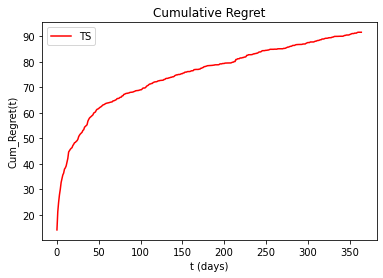

In [29]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward_TS3 - collected_rewards_TS3, axis=0)), 'r') 
plt.legend(["TS"])
plt.show()

- ### Standard Deviation Plot

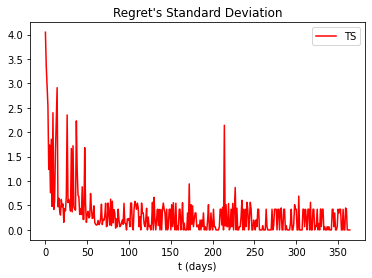

In [30]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward_TS3 - collected_rewards_TS3, axis=0), 'r')
plt.legend(["TS"])
plt.show()

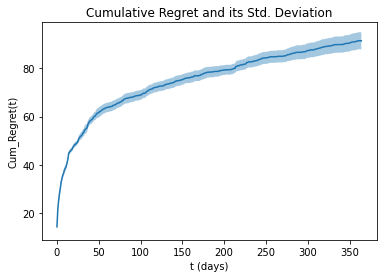

In [31]:
cum_R_TS3 = np.cumsum(opt_reward_TS3 - collected_rewards_TS3, axis = 1)
mean_cum_R_TS3 = np.mean(cum_R_TS3, axis = 0)
std_dev_TS3 = np.std(cum_R_TS3, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R_TS3)
plt.fill_between(range(n_days), mean_cum_R_TS3-std_dev_TS3, mean_cum_R_TS3+std_dev_TS3, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

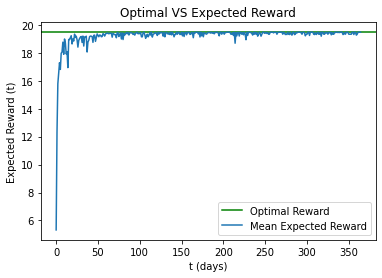

In [32]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward_TS3, color = 'green')
plt.plot(np.mean(collected_rewards_TS3, axis=0))
plt.xlabel("t (days)")
plt.ylabel("Expected Reward (t)")
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

- ### Ratio with respect to theoretica upper bound

In [26]:
ratio_list_TS3 = mean_cum_R_TS3/ub_ts
print('Last iteration Ratio is : %f' %ratio_list_TS3[-1])

Last iteration Ratio is : 0.321388


- ### Estimation of Uncertain Parameters

In [18]:
mean_CR_TS3 = np.mean(learner_TS3.cr_matrix_list, axis = 0)

print('Conversion Rates:\n%s' %str(mean_CR_TS3))

Conversion Rates:
[[0.74867231 0.63285432 0.40343181 0.27119478]
 [0.88061056 0.74624205 0.46942685 0.13677767]
 [0.84180858 0.68177559 0.49679949 0.41295547]
 [0.89761621 0.88612762 0.94580575 0.2217209 ]
 [0.79006907 0.63750778 0.33556772 0.40729443]]


In [19]:
print('THEORETICAL VALUES:\n\nConversion Rates :\n%s' %np.matrix(env.theoretical_values['conversion_rates'][0]))

THEORETICAL VALUES:

Conversion Rates :
[[0.79767162 0.63055866 0.43381617 0.25249254]
 [0.90878878 0.74750746 0.5        0.02275013]
 [0.84134475 0.69146246 0.5        0.0668072 ]
 [0.99931286 0.99180246 0.94520071 0.2118554 ]
 [0.7881446  0.65542174 0.2118554  0.00819754]]


## - UCB1

In [ ]:
# setting the run parameters
n_runs = 100
daily_users = 100
n_days = 365

In [ ]:
opt_reward = env.optimal_reward()[0]
ucb3 = step3_ucb1(len(prices), len(prices[0]), prices, env)
for _ in range(n_runs):
    ucb3.run(n_days, daily_users)

In [ ]:
# store the result
with open("ucb3", 'wb') as f1:
    pickle.dump(ucb3, f1)

In [ ]:
# load the result
with open("ucb3", 'rb') as f1:
    ucb3 = pickle.load(f1)

In [ ]:
step3_ucb1_collected_rewards = ucb3.collected_rewards
step3_ucb1_R = ucb3.regret
# plot of the result
mean_step3_ucb1_R = np.mean(step3_ucb1_R, axis=0)
std_dev_step3_ucb1 = np.std(step3_ucb1_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_step3_ucb1_R)
plt.fill_between(range(n_days), mean_step3_ucb1_R-std_dev_step3_ucb1, mean_step3_ucb1_R+std_dev_step3_ucb1, alpha=0.4)

In [ ]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(step3_ucb1_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

- ### Ratio with respect to theoretica upper bound

In [ ]:
ratio_list_ucb3 = mean_step3_ucb1_R/ub_ucb
print('Last iteration Ratio is : %f' %ratio_list_ucb3[-1])

In [ ]:
# last n pulled arms
print("Last n pulled arms:")
np.array(ucb3.pulled[-10:-1], dtype=np.int32)[:, 0].tolist()

In [ ]:
# ucb1 most pulled arms
combinations_data = [[] for i in range(1024)]
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append([i1, i2, i3, i4, i5])
                    c = np.array(np.array(ucb3.pulled, dtype=np.int32)[:, 0].tolist()) == [i1, i2, i3, i4, i5]
                    c = np.prod(c, axis=1)
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(np.count_nonzero(c))
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(env.expected_reward([i1, i2, i3, i4, i5]))
                    x = combinations_data
result = []
for i in range(20):
    result.append(x[np.argmax(np.array(x)[:, 1])])
    x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
print("Optimal arms combination:")
print(env.optimal_reward()[1], env.optimal_reward()[0])
print("\n\nUcb1 most pulled arms:")
print("(arms combination), (n° pulls), (exp rew)")
result

In [ ]:
ucb3.print_estimations()

# STEP 4 : Uncertain conversion rates, alpha ratio and number of products sold

## - TS

In [ ]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta_CR = np.array([a, b])
initial_beta_alpha = np.ones((2,5))
initial_n_prod_data = np.ones((2,5))
learner_TS4 = Step4_TS(env3, initial_beta_CR, initial_beta_alpha, initial_n_prod_data, learning_rate=1.0)

In [ ]:
# set the parameter for the algorithm execution
n_runs = 100
daily_users = 100
n_days = 365

# delete possible old informations form past runs 
learner_TS4.reward_history = []
learner_TS4.price_comb_history = []
learner_TS4.cr_matrix_list = []
learner_TS4.alpha_ratios_list = []
learner_TS4.n_prod_list = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner_TS4.run(n_days, daily_users)

# collect all informations for the plot
opt_reward_TS4 = learner_TS4.opt_reward
collected_rewards_TS4 = learner_TS4.reward_history

- ### Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [ ]:
with open('step4_TS', 'wb') as f: 
    pickle.dump(learner_TS4, f)

- ### Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [ ]:
with open('step4_TS', 'rb') as f: 
    learner_TS4 = pickle.load(f)
# collect all informations for the plot
opt_reward_TS4 = learner_TS4.opt_reward
collected_rewards_TS4 = learner_TS4.reward_history

- ### Cumulative Regret Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward_TS4 - collected_rewards_TS4, axis=0)), 'r')
plt.legend(["TS"])
plt.show()

- ### Standard Deviation Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward_TS4 - collected_rewards_TS4, axis=0), 'r')
plt.legend(["TS"])
plt.show()

In [ ]:
cum_R_TS4 = np.cumsum(opt_reward_TS4 - collected_rewards_TS4, axis = 1)
mean_cum_R_TS4 = np.mean(cum_R_TS4, axis = 0)
std_dev_TS4 = np.std(cum_R_TS4, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R_TS4)
plt.fill_between(range(n_days), mean_cum_R_TS4-std_dev_TS4, mean_cum_R_TS4+std_dev_TS4, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

In [ ]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward_TS4, color = 'green')
plt.plot(np.mean(collected_rewards_TS4, axis=0))
plt.xlabel("t (days)")
plt.ylabel("Expected Reward (t)")
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

- ### Ratio with respect to theoretica upper bound

In [ ]:
ratio_list_TS4 = mean_cum_R_TS4/ub_ts
print('Last iteration Ratio is : %f' %ratio_list_TS4[-1])

- ### Estimation of Uncertain Parameters

In [ ]:
mean_alpha_TS4 = np.mean(np.array(learner_TS4.alpha_ratios_list), axis = 0)
mean_n_prod_TS4 = np.mean(np.array(learner_TS4.n_prod_list), axis = 0)
mean_CR_TS4 = np.mean(learner_TS4.cr_matrix_list, axis = 0)

print('Conversion Rates:\n%s' %mean_CR_TS4)
print('\nAlpha Ratios : %s' % mean_alpha_TS4)
print('\nMean Number of product sold : %s' %mean_n_prod_TS4)

In [ ]:
print('THEORETICAL VALUES:\n\nConversion Rates :\n%s' %np.matrix(env.theoretical_values['conversion_rates'][0]))
print('\nAlpha Ratios : %s' %env.alpha_ratios[0] )
print('\nMean Number of product sold : %s' %(env.users[0].poisson_lambda+1))

## - UCB1

In [ ]:
# setting the run parameters
n_runs = 100
daily_users = 100
n_days = 365

In [ ]:
opt_reward = env.optimal_reward()[0]
ucb4 = step4_ucb1(len(prices), len(prices[0]), prices, env)
for _ in range(n_runs):
    ucb4.run(n_days, daily_users)

In [ ]:
# store the result
with open("ucb4", 'wb') as f1:
    pickle.dump(ucb4, f1)

In [ ]:
# load the result
with open("ucb4", 'rb') as f1:
    ucb4 = pickle.load(f1)

In [ ]:
step4_ucb1_collected_rewards = ucb4.collected_rewards
step4_ucb1_R = ucb4.regret
# plot of the result
mean_step4_ucb1_R = np.mean(step4_ucb1_R, axis=0)
std_dev_step4_ucb1 = np.std(step4_ucb1_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_step4_ucb1_R)
plt.fill_between(range(n_days), mean_step4_ucb1_R-std_dev_step4_ucb1, mean_step4_ucb1_R+std_dev_step4_ucb1, alpha=0.4)

In [ ]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(step4_ucb1_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

- ### Ratio with respect to theoretica upper bound

In [ ]:
ratio_list_ucb4 = mean_step4_ucb1_R/ub_ucb
print('Last iteration Ratio is : %f' %ratio_list_ucb4[-1])

In [ ]:
# last n pulled arms
print("Last n pulled arms:")
np.array(ucb4.pulled[-10:-1], dtype=np.int32)[:, 0].tolist()

In [ ]:
# ucb1 most pulled arms
combinations_data = [[] for i in range(1024)]
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append([i1, i2, i3, i4, i5])
                    c = np.array(np.array(ucb4.pulled, dtype=np.int32)[:, 0].tolist()) == [i1, i2, i3, i4, i5]
                    c = np.prod(c, axis=1)
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(np.count_nonzero(c))
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(env.expected_reward([i1, i2, i3, i4, i5]))
                    x = combinations_data
result = []
for i in range(20):
    result.append(x[np.argmax(np.array(x)[:, 1])])
    x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
print("Optimal arms combination:")
print(env.optimal_reward()[1], env.optimal_reward()[0])
print("\n\nUcb1 most pulled arms:")
print("(arms combination), (n° pulls), (exp rew)")
result

In [ ]:
ucb4.print_estimations()

# STEP 5 : Uncertain conversion rates and graph weights

## - TS

In [ ]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a_cr = np.ones((5,4))
b_cr = np.ones((5,4))
initial_beta_CR = np.array([a_cr, b_cr])
a_gw = np.ones((5,2))
b_gw = np.ones((5,2))
initial_beta_gw = np.array([a_gw, b_gw])
learner_TS5 = Step5_TS(env, initial_beta_CR, initial_beta_gw, learning_rate=1.0)

In [ ]:
# set the parameter for the algorithm execution
n_runs = 100
daily_users = 100
n_days = 365

# delete possible old informations form past runs 
learner_TS5.reward_history = []
learner_TS5.price_comb_history = []
learner_TS5.cr_matrix_list = []
learner_TS5.graph_weights_list = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner_TS5.run(n_days, daily_users)

# collect all informations for the plot
opt_reward_TS5 = learner_TS5.opt_reward
collected_rewards_TS5 = learner_TS5.reward_history

- ### Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [ ]:
with open('step5_TS', 'wb') as f: 
    pickle.dump(learner_TS5, f)

- ### Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [ ]:
with open('step5_TS', 'rb') as f: 
    learner_TS5 = pickle.load(f)
# collect all informations for the plot
opt_reward_TS5 = learner_TS5.opt_reward
collected_rewards_TS5 = learner_TS5.reward_history

- ### Cumulative Regret Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward_TS5 - collected_rewards_TS5, axis=0)), 'r')
plt.legend(["TS"])
plt.show()

- ### Standard Deviation Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward_TS5 - collected_rewards_TS5, axis=0), 'r')  
plt.legend(["TS"])
plt.show()

In [ ]:
cum_R_TS5 = np.cumsum(opt_reward_TS5 - collected_rewards_TS5, axis = 1)
mean_cum_R_TS5 = np.mean(cum_R_TS5, axis = 0)
std_dev_TS5 = np.std(cum_R_TS5, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R_TS5)
plt.fill_between(range(n_days), mean_cum_R_TS5-std_dev_TS5, mean_cum_R_TS5+std_dev_TS5, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

In [ ]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward_TS5, color = 'green')
plt.plot(np.mean(collected_rewards_TS5, axis=0))
plt.xlabel("t (days)")
plt.ylabel("Expected Reward (t)")
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

- ### Ratio with respect to theoretica upper bound

In [ ]:
ratio_list_TS5 = mean_cum_R_TS5/ub_ts
print('Last iteration Ratio is : %f' %ratio_list_TS5[-1])

- ### Estimation of Uncertain Parameters

In [ ]:
mean_CR_TS5 = np.mean(learner_TS5.cr_matrix_list, axis = 0)
mean_GW_TS5 = np.mean(learner_TS5.graph_weights_list, axis = 0)

print('Conversion Rates:\n%s' %mean_CR_TS5)
print('\nGraph Weights : %s' %mean_GW_TS5)

In [ ]:
print('THEORETICAL VALUES:\n\nConversion Rates :\n%s' %np.matrix(env.theoretical_values['conversion_rates'][0]))
print('\nGraph Weights :\n%s' %env.users[0].probabilities )

## - UCB1

In [ ]:
# setting the run parameters
n_runs = 100
daily_users = 100
n_days = 365

In [ ]:
opt_reward = env.optimal_reward()[0]
ucb5 = step5_ucb1(len(prices), len(prices[0]), prices, env)
for _ in range(n_runs):
    ucb5.run(n_days, daily_users)

In [ ]:
# store the result
with open("ucb5", 'wb') as f1:
    pickle.dump(ucb5, f1)

In [ ]:
# load the result
with open("ucb5", 'rb') as f1:
    ucb5 = pickle.load(f1)

In [ ]:
step5_ucb1_collected_rewards = ucb5.collected_rewards
step5_ucb1_R = ucb5.regret
# plot of the result
mean_step5_ucb1_R = np.mean(step5_ucb1_R, axis=0)
std_dev_step5_ucb1 = np.std(step5_ucb1_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_step5_ucb1_R)
plt.fill_between(range(n_days), mean_step5_ucb1_R-std_dev_step5_ucb1, mean_step5_ucb1_R+std_dev_step5_ucb1, alpha=0.4)
plt.show()

In [ ]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(step5_ucb1_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

- ### Ratio with respect to theoretica upper bound

In [ ]:
ratio_list_ucb5 = mean_step5_ucb1_R/ub_ucb
print('Last iteration Ratio is : %f' %ratio_list_ucb5[-1])

In [ ]:
# last n pulled arms
print("Last n pulled arms:")
np.array(ucb5.pulled[-10:-1], dtype=np.int32)[:, 0].tolist()

In [ ]:
# ucb1 most pulled arms
combinations_data = [[] for i in range(1024)]
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append([i1, i2, i3, i4, i5])
                    c = np.array(np.array(ucb5.pulled, dtype=np.int32)[:, 0].tolist()) == [i1, i2, i3, i4, i5]
                    c = np.prod(c, axis=1)
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(np.count_nonzero(c))
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(env.expected_reward([i1, i2, i3, i4, i5]))
                    x = combinations_data
result = []
for i in range(20):
    result.append(x[np.argmax(np.array(x)[:, 1])])
    x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
print("Optimal arms combination:")
print(env.optimal_reward()[1], env.optimal_reward()[0])
print("\n\nUcb1 most pulled arms:")
print("(arms combination), (n° pulls), (exp rew)")
result

In [ ]:
ucb5.print_estimations()

# STEP 6 : Abrupt Changes in Demand Curve with Uncertain Conversion Rates and Graph Weights

### - Abrupt Changes Setting Definition

In [34]:
#########################
# ABRUPT CHANGE SETTING #
#########################
n_days = 365

# We suppose to start in September, with relative high demand. Our hypothesis is that every season we have an
# abrupt change in demand curve
changes_dict ={ # BASE CASE: AUTUMN
    90 : {"mean": [10.1, 13.8, 23.2, 36.4, 43.7], "std": [3, 1.5, 2, 2.5, 2.5]}, # WINTER
    180 : {"mean": [9, 13, 22, 35, 42], "std": [3, 1.5, 2, 2.5, 2.5]}, # SPRING
    270 : {"mean": [8.2, 11.7, 20.5, 31.6, 39.1], "std": [3, 1.5, 2, 2.5, 2.5]} # SUMMER
}
opt_reward = env.optimal_reward()[0]
opt_reward_evolution = np.zeros(n_days)
original_res_price_param = copy.deepcopy(env.users[0].res_price_params)
for t in range(n_days):
    if t in changes_dict.keys(): 
        env.abrupt_change_deterministic([changes_dict[t]])
        opt_reward = env.optimal_reward()[0]
    opt_reward_evolution[t] = opt_reward

env.abrupt_change_deterministic([original_res_price_param])

### - SW UCB1

In [ ]:
3*np.sqrt(365) # value of sliding window used in the exercise lessons

In [ ]:
n_runs = 100
daily_users = 100

sw = int(3*np.sqrt(n_days))
sw_ucb = step6_sw_ucb(len(prices), len(prices[0]), prices, env, changes_dict, sw)
for _ in range(n_runs):
    sw_ucb.run(n_days, daily_users)

In [ ]:
# store the result
with open("sw_ucb", 'wb') as f1:
    pickle.dump(sw_ucb, f1)

In [ ]:
# load the result
with open("sw_ucb", 'rb') as f1:
    sw_ucb = pickle.load(f1)

In [ ]:
sw_ucb_collected_rewards = sw_ucb.collected_rewards
sw_ucb_R = sw_ucb.regret
# plot of the result
mean_sw_ucb_R = np.mean(sw_ucb_R, axis=0)
std_sw_ucb = np.std(sw_ucb_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_sw_ucb_R)
plt.fill_between(range(n_days), mean_sw_ucb_R-std_sw_ucb, mean_sw_ucb_R+std_sw_ucb, alpha=0.4)
changes_time = list(changes_dict.keys())
changes_n = len(changes_time)
plt.vlines(changes_time, [0]*changes_n, [max(mean_sw_ucb_R)]*changes_n, color = 'red', label= 'changes time')
plt.legend()
plt.show()

In [ ]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.plot(opt_reward_evolution, color = 'green')
plt.plot(np.mean(sw_ucb_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

### - Change Detection UCB1

In [ ]:
# change detection hyper parameters
m = 50
eps = 0.02
h = 0.3
cd_ucb = Step6_CD(len(prices), len(prices[0]), prices, env, changes_dict, m, eps, h)
# run setting (n_days fixed before)
n_runs = 100
daily_users = 100

for _ in range(n_runs):
    cd_ucb.run(n_days, daily_users)

In [ ]:
# store the result
with open("cd_ucb", 'wb') as f1:
    pickle.dump(cd_ucb, f1)

In [ ]:
# load the result
with open("cd_ucb", 'rb') as f1:
    cd_ucb = pickle.load(f1)

In [ ]:
cd_ucb_collected_rewards = cd_ucb.collected_rewards
cd_ucb_R = cd_ucb.regret
# plot of the result
mean_cd_ucb_R = np.mean(cd_ucb_R, axis=0)
std_cd_ucb = np.std(cd_ucb_R, axis=0)/np.sqrt(n_runs)
plt.figure(figsize=(10,8))
plt.plot(mean_cd_ucb_R)
plt.fill_between(range(n_days), mean_cd_ucb_R-std_cd_ucb, mean_cd_ucb_R+std_cd_ucb, alpha=0.4)
changes_time = list(changes_dict.keys())
changes_n = len(changes_time)
plt.vlines(changes_time, [0]*changes_n, [max(mean_cd_ucb_R)]*changes_n, color = 'red', label= 'changes time')
plt.legend()
plt.show()

In [ ]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.plot(opt_reward_evolution, color = 'green')
plt.plot(np.mean(cd_ucb_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

### - Sliding Window TS

In [35]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
# CONVERSION RATES INITIAL VALUES
a_cr = np.ones((5,4))*30
b_cr = np.ones((5,4))
initial_beta_CR = np.array([a_cr, b_cr])
# GRAPH WEIGHTS INITIAL VALUES
a_gw = np.ones((5,2))
b_gw = np.ones((5,2))
initial_beta_gw = np.array([a_gw, b_gw])
# SLIDING WINDOW WIDTH
sw = 60
# Learner initializer
learner_TS6 = Step6_TS_sw(env, initial_beta_CR, initial_beta_gw, sw, changes_dict)

In [36]:
# define run setting (n_days fixed for all step 6 methods)
n_runs = 50
daily_users = 100

# delete possible old informations form past runs 
learner_TS6.reward_history = []
learner_TS6.price_comb_history = []
learner_TS6.cr_matrix_list = []
learner_TS6.graph_weights_list = []
learner_TS6.CR_data_history = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner_TS6.run(n_days, daily_users)

# collect all informations for the plot
opt_reward_TS6 = learner_TS6.opt_reward
collected_rewards_TS6 = learner_TS6.reward_history

- ### Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [37]:
with open('step6_TS', 'wb') as f: 
    pickle.dump(learner_TS6, f)

- ### Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [ ]:
with open('step6_TS', 'rb') as f: 
    learner_TS6 = pickle.load(f)

- ### Cumulative Regret Plot

NameError: name 'changes_time' is not defined

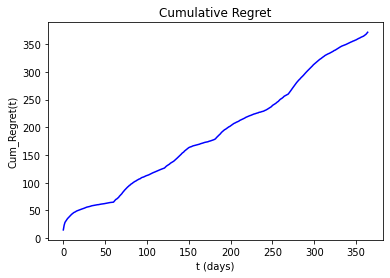

In [38]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
cum_regret = np.cumsum(np.mean(opt_reward_evolution - collected_rewards_TS6, axis=0))
plt.plot(cum_regret, 'blue', label = 'TS')
plt.vlines(changes_time, [0]*changes_n, [max(cum_regret)]*changes_n, color = 'red', label= 'changes time')
plt.legend()
plt.show()

- ### Standard Deviation Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
std_regret = np.std(opt_reward_evolution - collected_rewards_TS6, axis=0)
plt.plot(std_regret, 'blue', label = 'TS') 
plt.vlines(changes_time, [0]*changes_n, [max(std_regret)]*changes_n, color = 'red', label= 'changes time')
plt.legend()
plt.show()

In [ ]:
cum_R_TS6 = np.cumsum(opt_reward_evolution - collected_rewards_TS6, axis = 1)
mean_cum_R_TS6 = np.mean(cum_R_TS6, axis = 0)
std_dev_TS6 = np.std(cum_R_TS6, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R_TS6)
plt.fill_between(range(n_days), mean_cum_R_TS6-std_dev_TS6, mean_cum_R_TS6+std_dev_TS6, alpha=0.4)
plt.vlines(changes_time, [0]*changes_n, [max(mean_cum_R_TS6)]*changes_n, color = 'red', label= 'changes time')
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.legend
plt.show()

- ### Comparison between Optimal and Expected Reward

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Optimal VS Expected Reward")
plt.plot(opt_reward_evolution, color = 'green', label = "Optimal Reward")
plt.plot(np.mean(collected_rewards_TS6, axis=0), label = "Mean Expected Reward")
plt.xlabel("t (days)")
plt.ylabel("Expected Reward (t)")
plt.legend()
plt.show()

# STEP 7 : Context generation algorithms

## - TS

In [ ]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta_CR = np.array([a, b])
initial_beta_alpha = np.ones((2,5))
initial_n_prod_data = np.ones((2,5))
cg_confidence = 0.05
learner_TS7 = Step7_TS(env3, initial_beta_CR, initial_beta_alpha, initial_n_prod_data, cg_confidence)

In [ ]:
# set the parameter for the algorithm execution
n_runs = 100
daily_users = 100
n_days = 365

# delete possible old informations form past runs 
learner_TS7.reward_history = []
learner_TS7.context_history = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner_TS7.run(n_days, daily_users)

# collect all informations for the plot
opt_reward_TS7 = learner_TS7.opt_reward
collected_rewards_TS7 = learner_TS7.reward_history

- ### Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [ ]:
with open('step7_TS', 'wb') as f: 
    pickle.dump(learner_TS7, f)

- ### Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [ ]:
with open('step7_TS', 'rb') as f: 
    learner_TS7 = pickle.load(f)
# collect all informations for the plot
opt_reward_TS7 = learner_TS7.opt_reward
collected_rewards_TS7 = learner_TS7.reward_history

- ### Cumulative Regret Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward_TS7 - collected_rewards_TS7, axis=0)), 'r')
plt.legend(["TS"])
plt.show()

- ### Standard Deviation Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward_TS7 - collected_rewards_TS7, axis=0), 'r') 
plt.legend(["TS"])
plt.show()

In [ ]:
cum_R_TS7 = np.cumsum(opt_reward_TS7 - collected_rewards_TS7, axis = 1)
mean_cum_R_TS7 = np.mean(cum_R_TS7, axis = 0)
std_dev_TS7 = np.std(cum_R_TS7, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R_TS7)
plt.fill_between(range(n_days), mean_cum_R_TS7-std_dev_TS7, mean_cum_R_TS7+std_dev_TS7, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

In [ ]:
plt.figure(figsize = (8,6))
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward_TS7, color = 'green')
plt.axhline(aggr_opt_reward, color = 'red')
plt.plot(np.mean(collected_rewards_TS7, axis=0))
plt.xlabel("t (days)")
plt.ylabel("Expected Reward (t)")
plt.legend(["Optimal Reward","Aggregated Optimal Reward", "Mean Expected Reward"])
plt.show()

## - UCB1

In [ ]:
# setting the run parameters
n_runs = 100
daily_users = 100
n_days = 365

confidence = 0.05

In [ ]:
ucb7 = step7_ucb1(len(prices), len(prices[0]), prices, env3, confidence)

for _ in range(n_runs):
    ucb7.run(n_days, daily_users)

opt_reward_ucb7 = ucb7.opt_reward
collected_rewards_ucb7 = ucb7.reward_history

In [ ]:
# store the result
with open("ucb7", 'wb') as f1:
    pickle.dump(ucb7, f1)

In [39]:
# load the result
with open("ucb7", 'rb') as f1:
    ucb7 = pickle.load(f1)
# collect all informations for the plot
opt_reward_ucb7 = ucb7.opt_reward
collected_rewards_ucb7 = ucb7.reward_history

- ### Cumulative Regret Plot

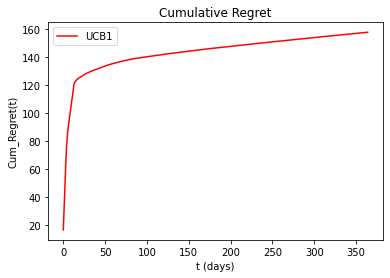

In [40]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward_ucb7 - collected_rewards_ucb7, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
plt.legend(["UCB1"])
plt.show()

- ### Standard Deviation Plot

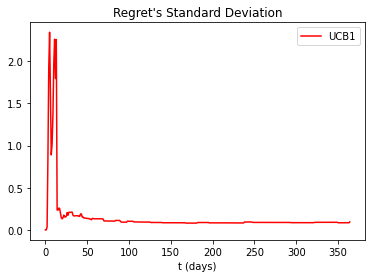

In [41]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward_ucb7 - collected_rewards_ucb7, axis=0), 'r')
plt.legend(["UCB1"])
plt.show()

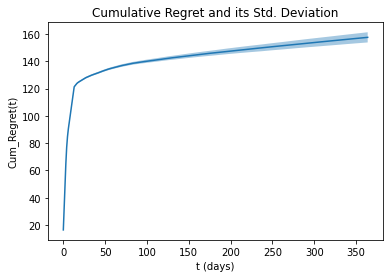

In [42]:
cum_R_ucb7 = np.cumsum(opt_reward_ucb7 - collected_rewards_ucb7, axis = 1)
mean_cum_R_ucb7 = np.mean(cum_R_ucb7, axis = 0)
std_dev_ucb7 = np.std(cum_R_ucb7, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R_ucb7)
plt.fill_between(range(n_days), mean_cum_R_ucb7-std_dev_ucb7, mean_cum_R_ucb7+std_dev_ucb7, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

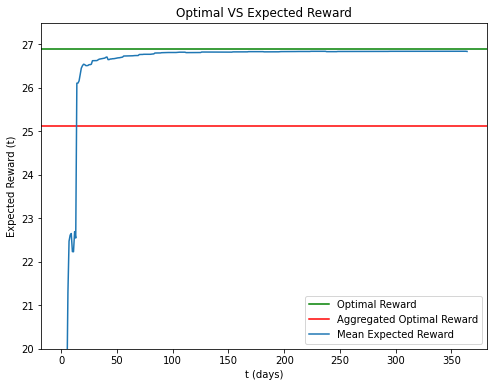

In [44]:
plt.figure(figsize = (8,6))
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward_ucb7, color = 'green')
plt.axhline(aggr_opt_reward, color = 'red')
plt.plot(np.mean(collected_rewards_ucb7, axis=0))
plt.xlabel("t (days)")
plt.ylabel("Expected Reward (t)")
plt.ylim([20, 27.5])
plt.legend(["Optimal Reward","Aggregated Optimal Reward", "Mean Expected Reward"])
plt.show()